In [1]:
import csv
import re
import os
import statistics
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import h5py

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential

from keras.layers.core import Activation, Dropout, Dense
from keras.layers.embeddings import Embedding
from keras.layers import Flatten, Conv1D, GlobalMaxPooling1D, MaxPooling1D, LSTM, GRU

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# load a saved model
from keras.models import load_model

from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


# Get Data

In [2]:
#open and prepare CSV file for data analysis
#NOTE:use pd dataframe next time
attributes = []
entries = []

with open("./data/winemag-data_first150k.csv") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        #get attribute names 
        if line_count == 0:            
            for r in row:
                attributes.append(r)
            
            attributes[0] = 'entry'
            
            line_count += 1

        else:
            #each entry as a dict of table attributes
            entry = {}
            n = 0
            for r in row:
                entry[attributes[n]] = r
                n+=1
                
            entries.append(entry)                  
            
            line_count += 1
    print(f'Processed {line_count} lines.')

Processed 150931 lines.


In [3]:
entries[0]

{'entry': '0',
 'country': 'US',
 'description': 'This tremendous 100% varietal wine hails from Oakville and was aged over three years in oak. Juicy red-cherry fruit and a compelling hint of caramel greet the palate, framed by elegant, fine tannins and a subtle minty tone in the background. Balanced and rewarding from start to finish, it has years ahead of it to develop further nuance. Enjoy 2022–2030.',
 'designation': "Martha's Vineyard",
 'points': '96',
 'price': '235.0',
 'province': 'California',
 'region_1': 'Napa Valley',
 'region_2': 'Napa',
 'variety': 'Cabernet Sauvignon',
 'winery': 'Heitz'}

In [4]:
#isolate each attribute
entry = []
country = []
description = []
designation = []
points = []
province = []
region_1 = []
region_2 = []
variety = []
winery = []


for e in entries:
    entry.append(e['entry'])
    country.append(e['country'])
    description.append(e['description'])
    designation.append(e['designation'])
    points.append(e['points'])
    province.append(e['province'])
    region_1.append(e['region_1'])
    region_2.append(e['region_2'])
    variety.append(e['variety'])
    winery.append(e['winery'])

# Part 1 Explore and prepare data
Will try to use text descriptions to try to predict either wine variety, points, or province

## Preprocess text descriptions

In [5]:
#pre process text in description attribute
def preprocess_text(sentence):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [6]:
description[0]

'This tremendous 100% varietal wine hails from Oakville and was aged over three years in oak. Juicy red-cherry fruit and a compelling hint of caramel greet the palate, framed by elegant, fine tannins and a subtle minty tone in the background. Balanced and rewarding from start to finish, it has years ahead of it to develop further nuance. Enjoy 2022–2030.'

In [7]:
preprocess_text(description[0])

'This tremendous varietal wine hails from Oakville and was aged over three years in oak Juicy red cherry fruit and compelling hint of caramel greet the palate framed by elegant fine tannins and subtle minty tone in the background Balanced and rewarding from start to finish it has years ahead of it to develop further nuance Enjoy '

In [8]:
print(variety[0],"\npoints:",points[0],"\n", province[0])

Cabernet Sauvignon 
points: 96 
 California


In [9]:
#preprocess all descriptions
n=0
for text in description:
    description[n] = preprocess_text(description[n])
    n+=1

In [10]:
#length of longest description
longest = 0
for t in description:
    s = t.split()
    if len(s) > longest:
        longest = len(s)

In [11]:
longest

132

## Explore varieties

In [12]:
#find all unique varities
varieties = []

n = 0

for v in variety:
    if v not in varieties:
        varieties.append(v)
        n+=1

print("There are",len(varieties),"varieties")

There are 632 varieties


In [13]:
#how common is each variety in dataset
variety_count = {}

for v in varieties:
    variety_count[v]=0
    
for v in variety:
    variety_count[v]+=1

In [14]:
#avg count of varities
sum(variety_count.values())/ len(varieties)

238.8132911392405

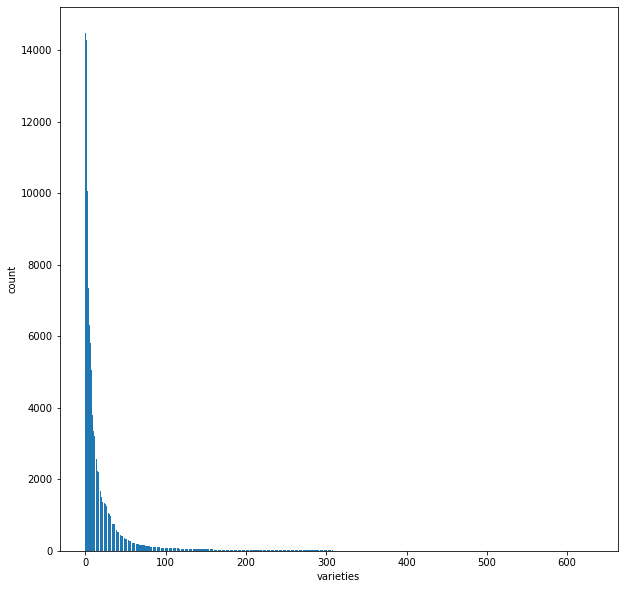

In [15]:
#look at distribution in graph
count_distribution = []

for v in variety_count.values():
    count_distribution.append(v)

count_distribution.sort(reverse=True)   

plt.figure(figsize=(10,10))
plt.bar(range(len(count_distribution)), count_distribution, width=0.8, bottom=None, align='center', data=None)
plt.xlabel('varieties')
plt.ylabel('count')
plt.show()

In [16]:
#standard deviation
statistics.stdev(count_distribution)

1216.3912983732207

In [17]:
#check quantile
np.quantile(count_distribution,.9)

205.39999999999986

### Conclusion on varieties

The skew in the number of samples for each variety is a problem that can drastically effect the prediction model. The upper 90% quartile only has 205 samples; this is still a small amount of samples to train on. Will have to play around with methods to balance the data or may cut out varieties under a certain threshold count.

### Preprocess varieties

In [18]:
#covert values to integer
int_variety = []
variety_key = {}

n=0

for v in variety:
    if v not in variety_key:
        variety_key[v] = n
        n+=1

for v in variety:
    int_variety.append(variety_key[v])

#print(int_variety)

## Explore points

In [19]:
#convert string int into int type

n = 0
for p in points:
    points[n] = int(p)
    n+=1

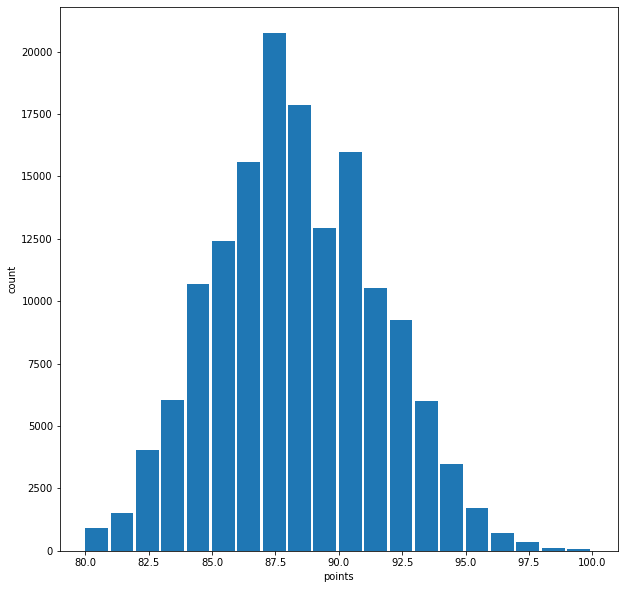

In [20]:
#look at point distribution
sorted_points = sorted(points)

plt.figure(figsize=(10,10))
plt.hist(sorted_points,bins=20, width = 0.9, bottom=None, data=None)
plt.xlabel('points')
plt.ylabel('count')
plt.show()

In [21]:
#standard deviation
statistics.stdev(points)

3.22239175898376

In [22]:
#check quantile
np.quantile(points,.5)

88.0

### Conclusion on points

The points distribution looks similar to a bell curve; this suggests that points may be a good attribute to use in predictive models.

## Explore province

In [23]:
#find all unique provinces
provinces = []

n = 0

for p in province:
    if p not in provinces:
        provinces.append(p)
        n+=1

print("There are",len(provinces),"provinces")

There are 456 provinces


In [24]:
#how common is each province in dataset
province_count = {}

for p in provinces:
    province_count[p]=0
    
for p in province:
    province_count[p]+=1

In [25]:
#avg count of varities
sum(province_count.values())/ len(provinces)

330.9868421052632

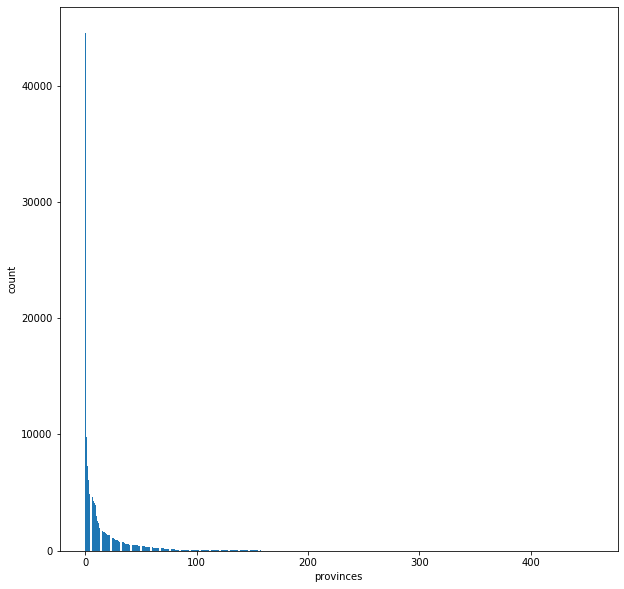

In [26]:
#look at distribution in graph
province_distribution = []

for p in province_count.values():
    province_distribution.append(p)

province_distribution.sort(reverse= True)   

plt.figure(figsize=(10,10))
plt.bar(range(len(province_distribution)), province_distribution, width=0.8, bottom=None, align='center', data=None)
plt.xlabel('provinces')
plt.ylabel('count')
plt.show()

In [27]:
#standard deviation
statistics.stdev(province_distribution)

2247.6183810068105

### conclusion on province

This data has the same issue as the varieties category. This has a heavy tail distribution in samples, California has over 40,000 samples while the second most surveyed province has just under 10,000 samples. Will try to use the same techniques that will be used on the varieties data in order to make it more useful for models.

### preprocess province

In [28]:
#covert values to integer
int_province = []
province_key = {}

n=0

for p in province:
    if p not in province_key:
        province_key[p] = n
        n+=1

for p in province:
    int_province.append(province_key[p])

#print(int_province)

## Merge all features into single list

In [29]:
#prep for train_test_split
zipped = [(a,b,c) for a,b,c in zip(points, int_variety, int_province)]

# Part 2: building predictive models based on descriptions

## Preprocess text embeddings with pretrained global vector model

In [30]:
if not os.path.exists("./glove.6B.100d.txt"):
    with open("glove.6B.100d.txt", "w+") as output:
        for i in range(0,8):
            print("Writing embeddings_" + str(i))
            with open("./embeddings/embeddings_"+str(i)) as part:
                output.write("".join(part.readlines()))
    print("Embedding file created!")
else:
    print("Embedding file already exists!")
    
print("Done!")

Embedding file already exists!
Done!


In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    description, 
    zipped, 
    test_size=0.20, 
    random_state=42)

In [32]:
#create word-to-index dictionary
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

# convert text to sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# tokenizer dictionary
dictionary = tokenizer.word_index

In [33]:
#length of current dictionary vocab
vocab_size = len(tokenizer.word_index) + 1

maxlen = longest

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [35]:
embeddings_dictionary = dict()

#file is too large to store on git, must download and place in folder manually
glove_file = open('./glove.6B.100d.txt', encoding="utf8")

#find embeddings for words in train set
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [36]:
#create embedding matrix for model
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [37]:
vocab_size == len(embedding_matrix)

True

### build models to predict points

In [38]:
#first build regression model on points
point_train = []
point_test = []

for p in y_train:
    point_train.append(p[0])
    
for p in y_test:
    point_test.append(p[0])

In [39]:
n = 0
for i in range(80,100+1):
    print(n)
    if (i+1)%5 == 0:
        n+=1

        
        

0
0
0
0
0
1
1
1
1
1
2
2
2
2
2
3
3
3
3
3
4


In [40]:
#format data for classification, predicting within point ranges 0-5
def classify_points(points, points_test, p_range=5):
    min_val = min(points)
    max_val = max(points)
    
    n = 0
    
    start = min_val
    
    classes = {}
    
    for i in range(min_val,max_val+1):
        classes[i]=n
        if (i+1)%p_range == 0:
            n+=1
        
    i = 0
    
    class_points = []
    class_points_test = []
    
    for p in points:
        class_points.append(classes[p])
        
    for p in points_test:
        class_points_test.append(classes[p])
    

    return class_points, class_points_test, classes, n+1
    
    

In [41]:
class_points, class_points_test, point_classes, class_num = classify_points(point_train, point_test)

In [42]:
point_classes

{80: 0,
 81: 0,
 82: 0,
 83: 0,
 84: 0,
 85: 1,
 86: 1,
 87: 1,
 88: 1,
 89: 1,
 90: 2,
 91: 2,
 92: 2,
 93: 2,
 94: 2,
 95: 3,
 96: 3,
 97: 3,
 98: 3,
 99: 3,
 100: 4}

In [43]:
class_points[0:5]

[0, 1, 1, 2, 1]

In [44]:
point_train[0:5]

[83, 87, 89, 92, 89]

### 1D CNN

In [45]:
# set parameters:
max_features = vocab_size
maxlen = 132
BATCH_SIZE = 128
embedding_dims = 50
filters = 250
kernel_size = 3

In [46]:
cnn = Sequential()

# start with an efficient embedding layer which maps
# vocab indices into embedding_dims dimensions
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

cnn.add(embedding_layer)


# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
cnn.add(Conv1D(BATCH_SIZE,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
cnn.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
cnn.add(Dense(BATCH_SIZE))
cnn.add(Activation('relu'))

# We project onto a single layer
cnn.add(Dense(1))


cnn.compile(loss='mse',
              optimizer='adam',
              metrics=['accuracy'])

In [47]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 132, 100)          2842400   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 130, 128)          38528     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 2,897,569
Trainable params: 55,169
Non-trainable params: 2,842,400
_______________________________________

In [48]:
cnn = load_model('./models/best_cnn.h5')

In [ ]:
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=350)
mc = ModelCheckpoint('./models/best_cnn.h5', monitor='val_accuracy', verbose=1, mode='max',  save_best_only=True)

cnn_history = cnn.fit(X_train, point_train, 
                        batch_size=BATCH_SIZE, 
                        epochs=10000, 
                        verbose=0, 
                        validation_data=(X_test, point_test),
                        callbacks=[es,mc])


In [49]:
cnn_score = cnn.evaluate(X_test, point_test, verbose=1)
print("Test Score:", cnn_score[0])
print("Test Accuracy:", cnn_score[1])

30186/30186 [==============================] - 3s 113us/step
Test Score: 2.9719024417904745
Test Accuracy: 0.29513680934906006


#### with dropout layers and point classes

In [ ]:
dcnn = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

dcnn.add(embedding_layer)

dcnn.add(Dropout(0.2))

# Convolution1D will learn filters
# word group filters of size filter_length:
dcnn.add(Conv1D(BATCH_SIZE,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))

# use max pooling:
dcnn.add(GlobalMaxPooling1D())

# add vanilla hidden layer:
dcnn.add(Dense(BATCH_SIZE))
dcnn.add(Dropout(0.2))
dcnn.add(Activation('relu'))

# We project onto a single layer
dcnn.add(Dense(1))


dcnn.compile(loss='mse',
              optimizer='adam',
              metrics=['accuracy'])

In [50]:
dcnn = load_model('./models/best_dcnn.h5')

In [ ]:
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300)
mc = ModelCheckpoint('./models/best_dcnn.h5', monitor='val_accuracy', verbose=1, mode='max', save_best_only=True)

#using dropout
dcnn_history = dcnn.fit(X_train, class_points, 
                        batch_size=BATCH_SIZE, 
                        epochs=10000, 
                        verbose=0, 
                        validation_data=(X_test, class_points_test),
                        callbacks=[es,mc])

In [51]:
dcnn_score = dcnn.evaluate(X_test, class_points_test, verbose=1)

30186/30186 [==============================] - 2s 60us/step


In [52]:
print("Test Score:", dcnn_score[0])
print("Test Accuracy:", dcnn_score[1])

Test Score: 0.3292250704976205
Test Accuracy: 0.6127012372016907


#### (TODO) using classified points model (range=5)

### 1D CNN w/ LSTM

In [ ]:
lstm = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm.add(embedding_layer)
lstm.add(Dropout(0.2))
lstm.add(Conv1D(BATCH_SIZE, 5, activation='relu'))
lstm.add(Dropout(0.2))
lstm.add(LSTM(BATCH_SIZE))
lstm.add(Dense(1))

lstm.compile(optimizer='adam', loss='mse', metrics=['acc'])

In [ ]:
lstm.summary()

In [ ]:
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=350)
mc = ModelCheckpoint('./models/best_lstm.h5', monitor='val_acc', verbose=1, mode='max',  save_best_only=True)

lstm_history = lstm.fit(X_train, point_train, 
                        batch_size=BATCH_SIZE, 
                        epochs=10000, 
                        verbose=0, 
                        validation_data=(X_test, point_test),
                        callbacks=[es,mc])

### 2 CNN layer into LSTM

In [ ]:
lstm2 = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm2.add(embedding_layer)
lstm2.add(Dropout(0.2))
lstm2.add(Conv1D(BATCH_SIZE, 5, activation='relu'))
lstm2.add(MaxPooling1D(5))
lstm2.add(Dropout(0.2))
lstm2.add(Conv1D(BATCH_SIZE, 5, activation='relu'))
lstm2.add(Dropout(0.2))
lstm2.add(LSTM(BATCH_SIZE))
lstm2.add(Dense(1))

lstm2.compile(optimizer='adam', loss='mse', metrics=['acc'])

In [ ]:
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=500)
mc = ModelCheckpoint('./models/best_lstm2.h5', monitor='val_acc', verbose=1, mode='max', save_best_only=True)

lstm2_history = lstm2.fit(X_train, point_train, 
                        batch_size=BATCH_SIZE, 
                        epochs=10000, 
                        verbose=0, 
                        validation_data=(X_test, point_test),
                        callbacks=[es,mc])

### CNN with GRU layer

In [ ]:
#gru is good for distinguishing context with word relationships
gru = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

gru.add(embedding_layer)
gru.add(Dropout(0.2))
gru.add(Conv1D(BATCH_SIZE, 5, activation='relu'))
gru.add(Dropout(0.2))
gru.add(GRU(BATCH_SIZE, recurrent_dropout=0.2))
gru.add(Dense(1))

gru.compile(optimizer='adam', loss='mse', metrics=['acc'])

In [ ]:
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=350)
mc = ModelCheckpoint('./models/best_gru.h5', monitor='val_acc', verbose=1, mode='max',  save_best_only=True)

gru_history = gru.fit(X_train, point_train, 
                        batch_size=BATCH_SIZE, 
                        epochs=10000, 
                        verbose=0, 
                        validation_data=(X_test, point_test),
                        callbacks=[es,mc])